Problem statement: To build a CNN based model which can accurately detect melanoma. Melanoma is a type of cancer that can be deadly if not detected early. It accounts for 75% of skin cancer deaths. A solution which can evaluate images and alert the dermatologists about the presence of melanoma has the potential to reduce a lot of manual effort needed in diagnosis.

Importing all the important libraries

In [48]:
import pathlib
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import PIL
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import BatchNormalization
from tensorflow.python.keras.layers import Dense, Dropout, Activation, Flatten, Conv2D, MaxPool2D
from tensorflow.keras.optimizers import RMSprop
from glob import glob

Importing Skin Cancer Data

In [49]:
## If you are using the data by mounting the google drive, use the following :
from google.colab import drive
drive.mount('/content/gdrive')

##Ref:https://towardsdatascience.com/downloading-datasets-into-google-drive-via-google-colab-bcb1b30b0166

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [50]:
# Defining the path for train and test images
root_path = '/content/gdrive/MyDrive/skin-cancer-dataset'
data_dir_train = pathlib.Path(root_path + '/Train')
data_dir_test = pathlib.Path(root_path + '/Test')

In [51]:
image_count_train = len(list(data_dir_train.glob('*/*.jpg')))
print(image_count_train)
image_count_test = len(list(data_dir_test.glob('*/*.jpg')))
print(image_count_test)

2239
118


This assignment uses a dataset of about 2357 images of skin cancer types. The dataset contains 9 sub-directories in each train and test subdirectories. The 9 sub-directories contains the images of 9 skin cancer types respectively.

Load using keras.preprocessing

Let's load these images off disk using the helpful image_dataset_from_directory utility.

Create a dataset

Define some parameters for the loader:

In [52]:
batch_size = 32
img_height = 180
img_width = 180

In [53]:
## Write your train dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)


Found 2239 files belonging to 9 classes.
Using 1792 files for training.


In [54]:
## Write your validation dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 2239 files belonging to 9 classes.
Using 447 files for validation.


In [55]:
# List out all the classes of skin cancer and store them in a list.
# You can find the class names in the class_names attribute on these datasets.
# These correspond to the directory names in alphabetical order.
class_names = train_ds.class_names
print(class_names)

['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']


### Visualize the data
#### Todo, create a code to visualize one instance of all the nine classes present in the dataset

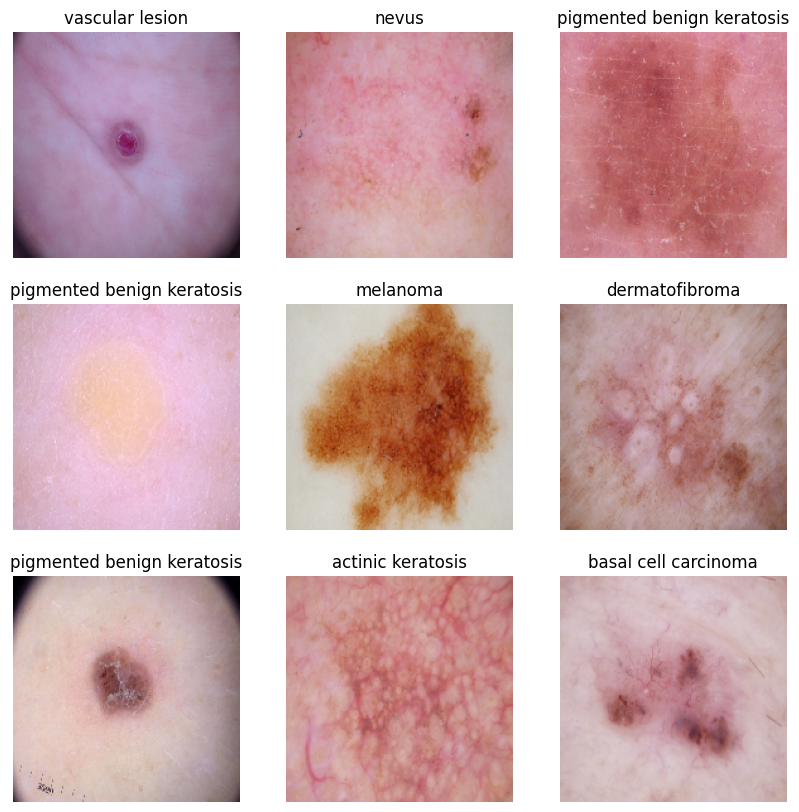

In [56]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

The `image_batch` is a tensor of the shape `(32, 180, 180, 3)`. This is a batch of 32 images of shape `180x180x3` (the last dimension refers to color channels RGB). The `label_batch` is a tensor of the shape `(32,)`, these are corresponding labels to the 32 images.

`Dataset.cache()` keeps the images in memory after they're loaded off disk during the first epoch.

`Dataset.prefetch()` overlaps data preprocessing and model execution while training.

In [57]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

### Create the model
#### Todo: Create a CNN model, which can accurately detect 9 classes present in the dataset. Use ```layers.experimental.preprocessing.Rescaling``` to normalize pixel values between (0,1). The RGB channel values are in the `[0, 255]` range. This is not ideal for a neural network. Here, it is good to standardize values to be in the `[0, 1]`

In [58]:
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
num_classes = 9
model = Sequential([
                    layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width,3))
])
model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same',
                 activation ='relu', input_shape = (180, 180, 32)))
model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same',
                 activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same',
                 activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Conv2D(filters = 64, kernel_size = (5,5),padding = 'Same',
                 activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Conv2D(filters = 64, kernel_size = (5,5),padding = 'Same',
                 activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Dropout(0.25))


model.add(Flatten())
model.add(Dense(num_classes, activation = "softmax"))

In [59]:
# View the summary of all layers
model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_3 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_18 (Conv2D)          (None, 180, 180, 32)      2432      
                                                                 
 conv2d_19 (Conv2D)          (None, 180, 180, 32)      25632     
                                                                 
 max_pooling2d_13 (MaxPooli  (None, 90, 90, 32)        0         
 ng2D)                                                           
                                                                 
 conv2d_20 (Conv2D)          (None, 90, 90, 32)        25632     
                                                                 
 max_pooling2d_14 (MaxPooli  (None, 45, 45, 32)        0         
 ng2D)                                                

### Compile the model
Choose an appropirate optimiser and loss function for model training

In [60]:
### Todo, choose an appropirate optimiser and loss function

optimizer = 'adam'
loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
#loss_fn = 'binary_crossentropy'
model.compile(optimizer=optimizer,
              loss=loss_fn,
              metrics=['accuracy'])

In [61]:
# View the summary of all layers
model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_3 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_18 (Conv2D)          (None, 180, 180, 32)      2432      
                                                                 
 conv2d_19 (Conv2D)          (None, 180, 180, 32)      25632     
                                                                 
 max_pooling2d_13 (MaxPooli  (None, 90, 90, 32)        0         
 ng2D)                                                           
                                                                 
 conv2d_20 (Conv2D)          (None, 90, 90, 32)        25632     
                                                                 
 max_pooling2d_14 (MaxPooli  (None, 45, 45, 32)        0         
 ng2D)                                                

### Train the model

In [62]:
epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
56/56 [==============================] - 321s 2s/step - loss: 2.0410 - accuracy: 0.2199 - val_loss: 1.9788 - val_accuracy: 0.2081
Epoch 2/20
56/56 [==============================] - 5s 91ms/step - loss: 1.9162 - accuracy: 0.2651 - val_loss: 1.8297 - val_accuracy: 0.3244
Epoch 3/20
56/56 [==============================] - 5s 90ms/step - loss: 1.8143 - accuracy: 0.3047 - val_loss: 1.9526 - val_accuracy: 0.2685
Epoch 4/20
56/56 [==============================] - 5s 90ms/step - loss: 1.7389 - accuracy: 0.3499 - val_loss: 1.6820 - val_accuracy: 0.4318
Epoch 5/20
56/56 [==============================] - 5s 91ms/step - loss: 1.7159 - accuracy: 0.3705 - val_loss: 1.6376 - val_accuracy: 0.4027
Epoch 6/20
56/56 [==============================] - 5s 91ms/step - loss: 1.6183 - accuracy: 0.4029 - val_loss: 1.5547 - val_accuracy: 0.4340
Epoch 7/20
56/56 [==============================] - 5s 89ms/step - loss: 1.5377 - accuracy: 0.4453 - val_loss: 1.5949 - val_accuracy: 0.4206
Epoch 8/20
56

### Visualizing training results

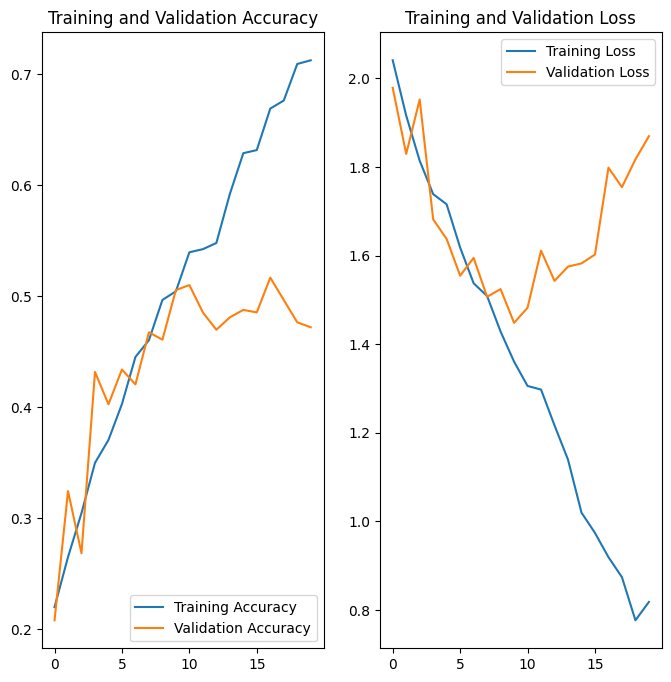

In [63]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

The model is overfitting because we can also see difference in loss functions in training & test around the 10-11th epoch

The accuracy is just around 70% because there are enough features to remember the pattern.

In [64]:
loss, accuracy = model.evaluate(train_ds, verbose=1,)
loss_v, accuracy_v = model.evaluate(val_ds, verbose=1)

print("Accuracy: ", accuracy)
print("Validation Accuracy: ",accuracy_v)
print("Loss: ",loss)
print("Validation Loss", loss_v)


14/14 [==============================] - 0s 20ms/step - loss: 1.8696 - accuracy: 0.4720
Accuracy:  0.8125
Validation Accuracy:  0.47203579545021057
Loss:  0.5966382622718811
Validation Loss 1.8696362972259521


Above train and validation accuracy result clearly shows that model is Overfit and we need to chose right data augumentation strategy

In [65]:
# Todo, after you have analysed the model fit history for presence of underfit or overfit, choose an appropriate data augumentation strategy.
data_augument = keras.Sequential([
                             layers.experimental.preprocessing.RandomFlip(mode="horizontal_and_vertical",input_shape=(img_height,img_width,3)),
                             layers.experimental.preprocessing.RandomRotation(0.2, fill_mode='reflect'),
                             layers.experimental.preprocessing.RandomZoom(height_factor=(0.2, 0.3), width_factor=(0.2, 0.3), fill_mode='reflect')
])

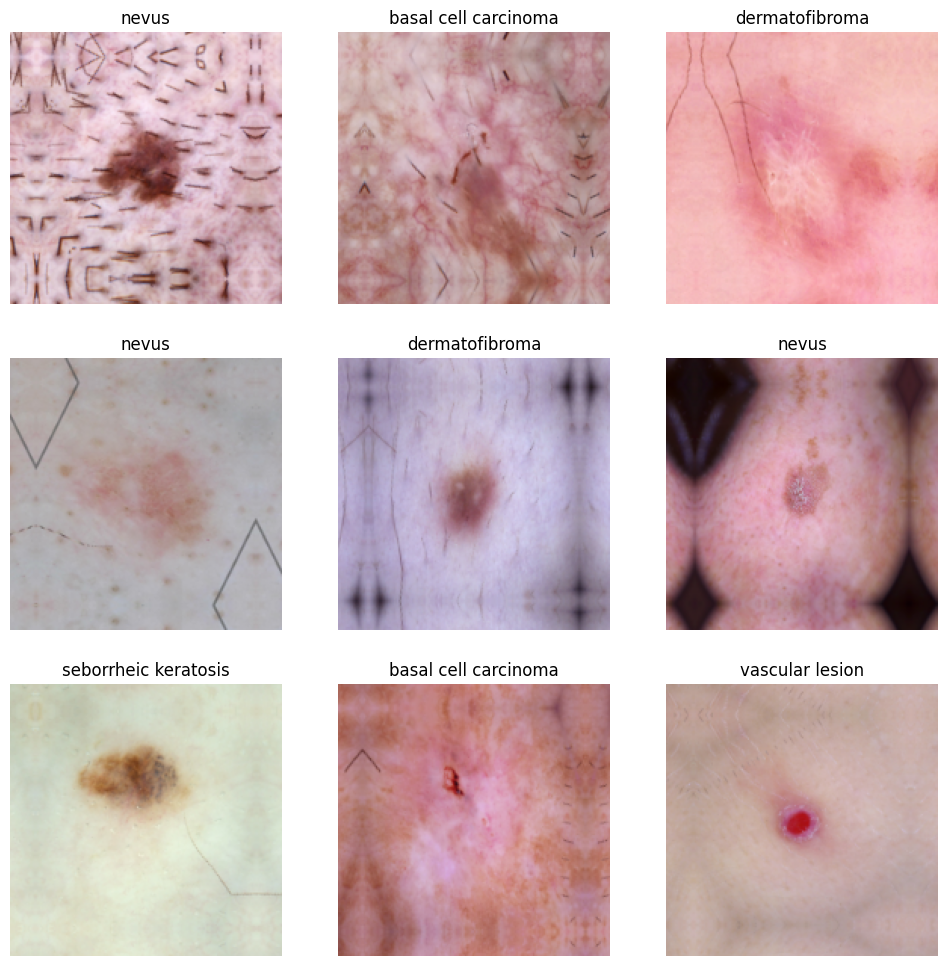

In [66]:
# Todo, visualize how your augmentation strategy works for one instance of training image.
plt.figure(figsize=(12, 12))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(data_augument(images)[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

### Todo:
### Create the model, compile and train the model


In [67]:
## You can use Dropout layer if there is an evidence of overfitting in your findings

from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
num_classes = 9
model = Sequential([ data_augument,
                    layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width,3))

])
model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same',
                 activation ='relu', input_shape = (180, 180, 32)))
model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same',
                 activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Conv2D(filters = 64, kernel_size = (5,5),padding = 'Same',
                 activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Conv2D(filters = 64, kernel_size = (5,5),padding = 'Same',
                 activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Dropout(0.25))


model.add(Flatten())
model.add(Dense(num_classes, activation = "softmax"))


### Compiling the model

In [68]:
### Your code goes here
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

### Training the model

In [69]:
## Your code goes here, note: train your model for 20 epochs
epochs=20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
56/56 [==============================] - 42s 127ms/step - loss: 2.0936 - accuracy: 0.1931 - val_loss: 2.0269 - val_accuracy: 0.2058
Epoch 2/20
56/56 [==============================] - 6s 103ms/step - loss: 2.0425 - accuracy: 0.1920 - val_loss: 2.0461 - val_accuracy: 0.1924
Epoch 3/20
56/56 [==============================] - 6s 105ms/step - loss: 2.0299 - accuracy: 0.1925 - val_loss: 2.0322 - val_accuracy: 0.2058
Epoch 4/20
56/56 [==============================] - 6s 103ms/step - loss: 2.0204 - accuracy: 0.2076 - val_loss: 2.0402 - val_accuracy: 0.2103
Epoch 5/20
56/56 [==============================] - 6s 102ms/step - loss: 2.0209 - accuracy: 0.2020 - val_loss: 2.0258 - val_accuracy: 0.2081
Epoch 6/20
56/56 [==============================] - 6s 101ms/step - loss: 2.0171 - accuracy: 0.2121 - val_loss: 2.0443 - val_accuracy: 0.1924
Epoch 7/20
56/56 [==============================] - 6s 102ms/step - loss: 2.0145 - accuracy: 0.1975 - val_loss: 2.0291 - val_accuracy: 0.2081
Epoch

### Visualizing the results

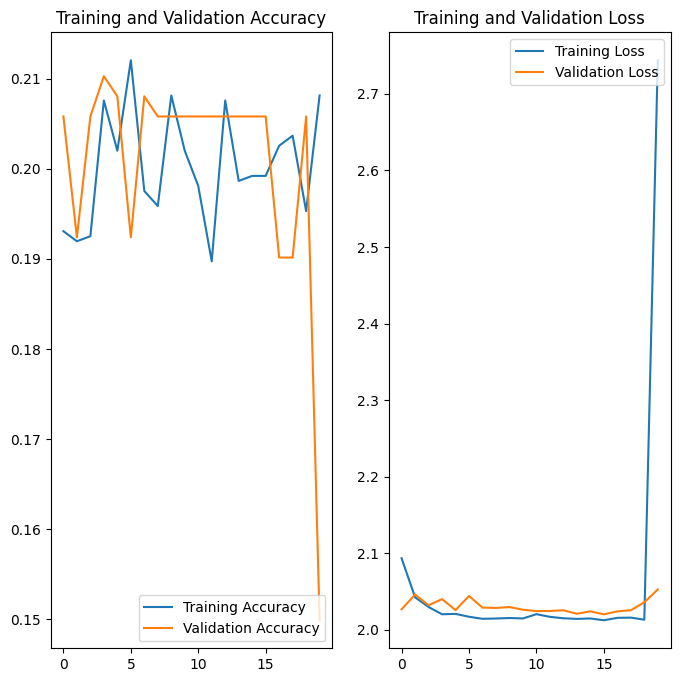

In [70]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

There is no improvement in accuracy but we can definitely see the overfitting problem has solved due to data augmentation

We can increase the epochs to increase the accuracy so it's too early for judgement

#### **Todo:** Find the distribution of classes in the training dataset.
#### **Context:** Many times real life datasets can have class imbalance, one class can have proportionately higher number of samples compared to the others. Class imbalance can have a detrimental effect on the final model quality. Hence as a sanity check it becomes important to check what is the distribution of classes in the data.

<Figure size 1000x1000 with 0 Axes>

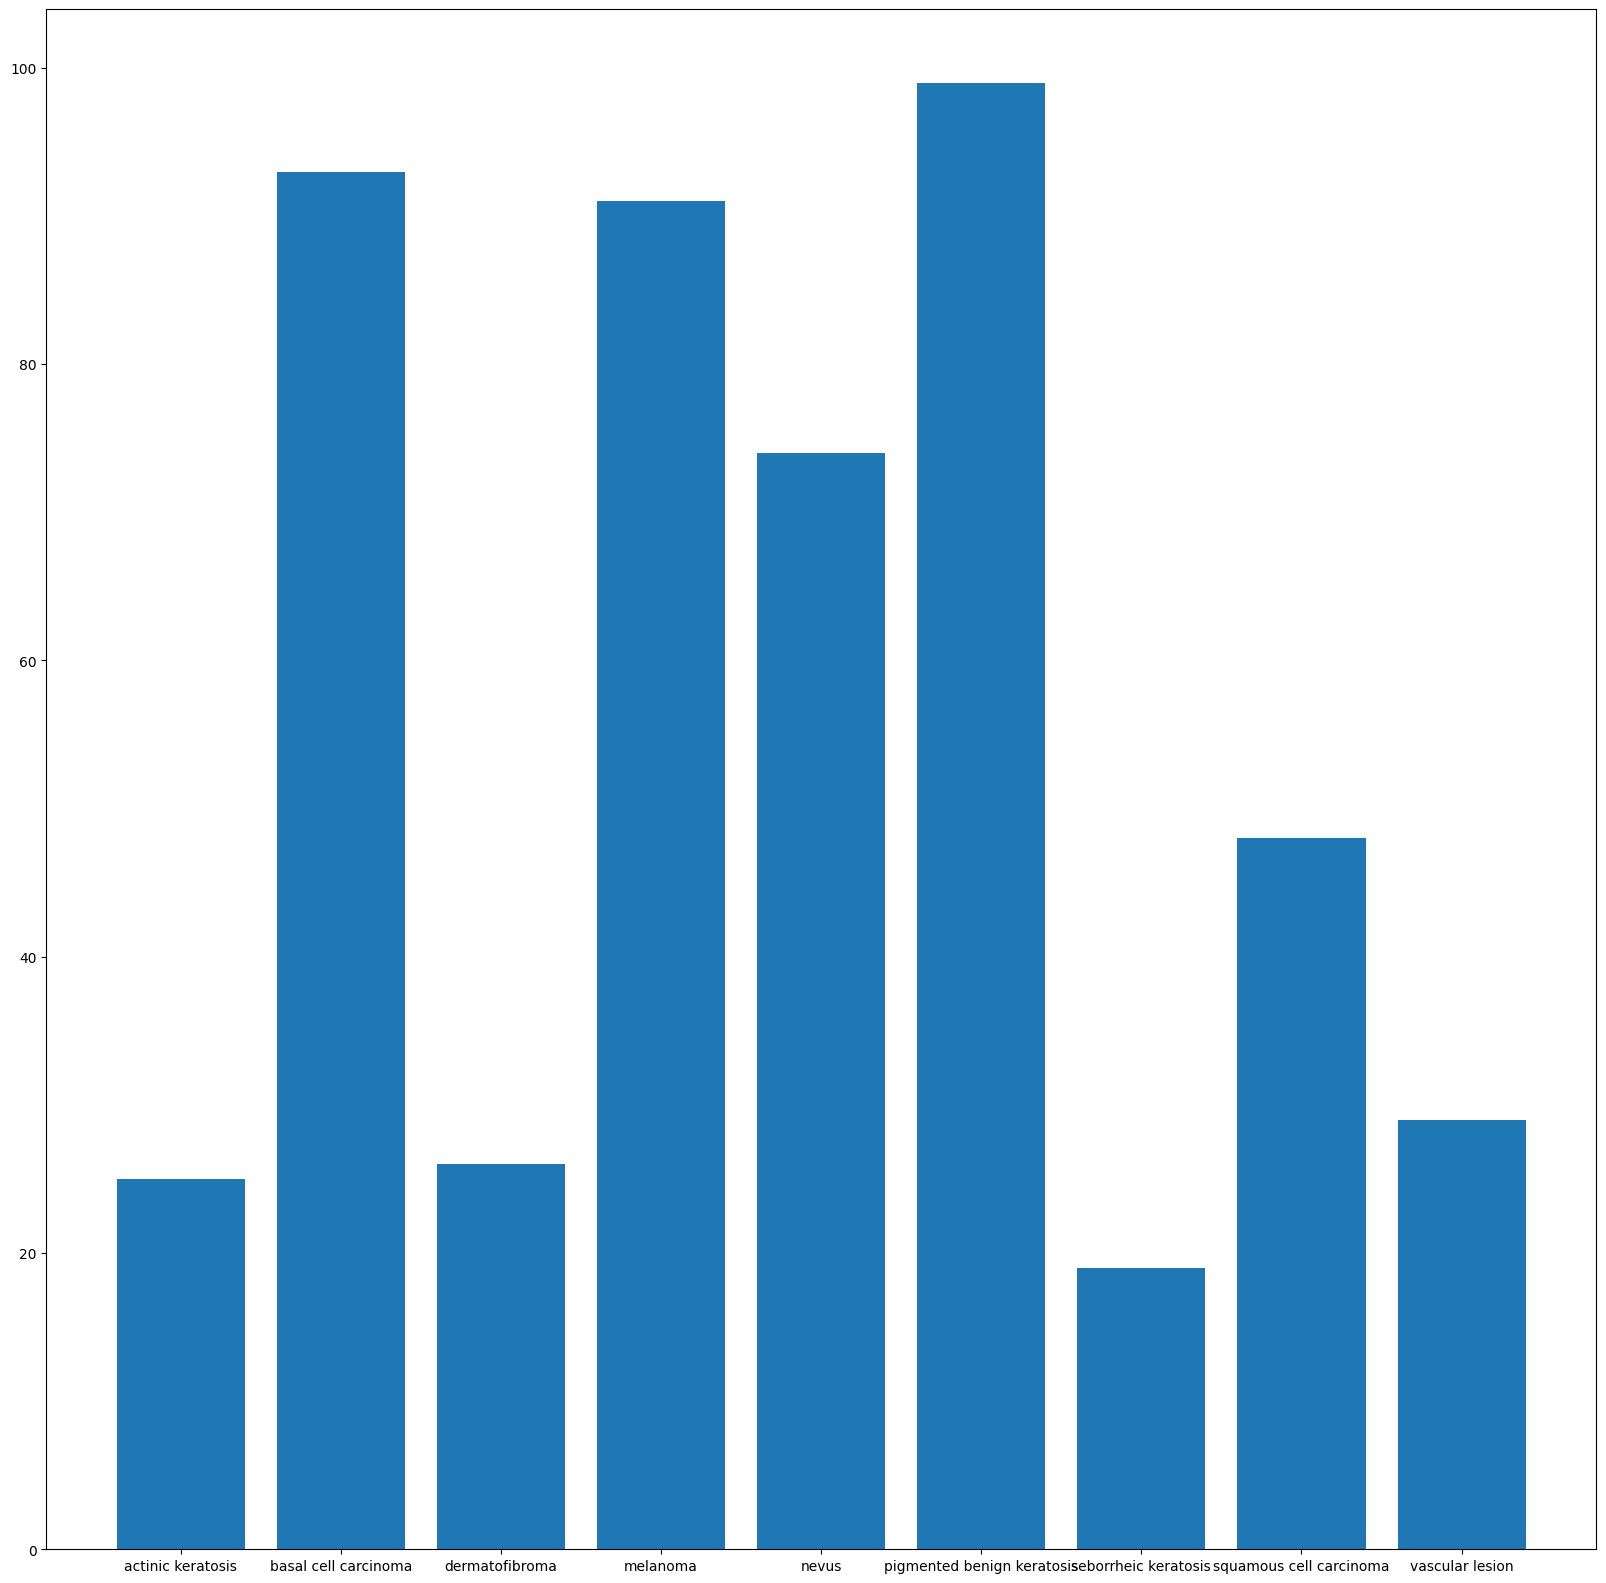

In [71]:
## Your code goes here.
data = dict()

for i in class_names:
  data[i] = []

plt.figure(figsize=(10, 10))
for images, labels in train_ds:
  for i in range(9):
    data[class_names[labels[i]]].append(images[i].numpy().astype("uint8"))

for i in data:
  data[i] = len(data[i])

f = plt.figure()
f.set_figwidth(20)
f.set_figheight(20)

plt.bar(range(len(data)), list(data.values()), align='center')
plt.xticks(range(len(data)), list(data.keys()))
plt.show()

- Seborrheic keratosis is having the lowest distribution
- Pigmented Benign keratosis is having the highest distribution of data

#### **Todo:** Rectify the class imbalance
#### **Context:** You can use a python package known as `Augmentor` (https://augmentor.readthedocs.io/en/master/) to add more samples across all classes so that none of the classes have very few samples.

In [ ]:
!pip install Augmentor

To use `Augmentor`, the following general procedure is followed:

1. Instantiate a `Pipeline` object pointing to a directory containing your initial image data set.<br>
2. Define a number of operations to perform on this data set using your `Pipeline` object.<br>
3. Execute these operations by calling the `Pipeline’s` `sample()` method.


In [ ]:
class_names

['actinic keratosis',
 'basal cell carcinoma',
 'dermatofibroma',
 'melanoma',
 'nevus',
 'pigmented benign keratosis',
 'seborrheic keratosis',
 'squamous cell carcinoma',
 'vascular lesion']

In [72]:
path_to_training_dataset="/content/gdrive/MyDrive/skin-cancer-dataset/Train/"
import Augmentor
for i in class_names:
    #print(path_to_training_dataset + i)
    p = Augmentor.Pipeline(path_to_training_dataset + i)
    p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
    p.sample(500) ## We are adding 500 samples per class to make sure that none of the classes are sparse.

Initialised with 114 image(s) found.
Output directory set to /content/gdrive/MyDrive/skin-cancer-dataset/Train/actinic keratosis/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7F3A1BCB8D90>: 100%|██████████| 500/500 [00:17<00:00, 28.96 Samples/s]


Initialised with 376 image(s) found.
Output directory set to /content/gdrive/MyDrive/skin-cancer-dataset/Train/basal cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F3A19D57A30>: 100%|██████████| 500/500 [00:17<00:00, 29.25 Samples/s]


Initialised with 95 image(s) found.
Output directory set to /content/gdrive/MyDrive/skin-cancer-dataset/Train/dermatofibroma/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7F3A1B6289A0>: 100%|██████████| 500/500 [00:17<00:00, 28.11 Samples/s]


Initialised with 438 image(s) found.
Output directory set to /content/gdrive/MyDrive/skin-cancer-dataset/Train/melanoma/output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x7F3A187CFA90>: 100%|██████████| 500/500 [01:28<00:00,  5.63 Samples/s]


Initialised with 357 image(s) found.
Output directory set to /content/gdrive/MyDrive/skin-cancer-dataset/Train/nevus/output.

Processing <PIL.Image.Image image mode=RGB size=3072x2304 at 0x7F3A980A2F50>: 100%|██████████| 500/500 [01:19<00:00,  6.26 Samples/s]


Initialised with 462 image(s) found.
Output directory set to /content/gdrive/MyDrive/skin-cancer-dataset/Train/pigmented benign keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F3A241D3820>: 100%|██████████| 500/500 [00:17<00:00, 28.62 Samples/s]


Initialised with 77 image(s) found.
Output directory set to /content/gdrive/MyDrive/skin-cancer-dataset/Train/seborrheic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x7F3A19A414B0>: 100%|██████████| 500/500 [00:42<00:00, 11.75 Samples/s]


Initialised with 181 image(s) found.
Output directory set to /content/gdrive/MyDrive/skin-cancer-dataset/Train/squamous cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F3A1B6E9510>: 100%|██████████| 500/500 [00:17<00:00, 28.62 Samples/s]


Initialised with 139 image(s) found.
Output directory set to /content/gdrive/MyDrive/skin-cancer-dataset/Train/vascular lesion/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F3A19CD94E0>: 100%|██████████| 500/500 [00:18<00:00, 27.52 Samples/s]


Augmentor has stored the augmented images in the output sub-directory of each of the sub-directories of skin cancer types.. Lets take a look at total count of augmented images.

In [73]:
image_count_train = len(list(data_dir_train.glob('*/output/*.jpg')))
print(image_count_train)

4500


### Lets see the distribution of augmented data after adding new images to the original training data.

In [74]:
path_list = [x for x in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
path_list

['/content/gdrive/MyDrive/skin-cancer-dataset/Train/vascular lesion/output/vascular lesion_original_ISIC_0032866.jpg_11dc3a9e-c0b1-4141-b324-f05cc2ea98c8.jpg',
 '/content/gdrive/MyDrive/skin-cancer-dataset/Train/vascular lesion/output/vascular lesion_original_ISIC_0025606.jpg_447b301b-abd6-46d4-94bd-f6aa23ebe6f9.jpg',
 '/content/gdrive/MyDrive/skin-cancer-dataset/Train/vascular lesion/output/vascular lesion_original_ISIC_0025807.jpg_9bf9db8b-13d5-4df0-b741-74e391516809.jpg',
 '/content/gdrive/MyDrive/skin-cancer-dataset/Train/vascular lesion/output/vascular lesion_original_ISIC_0030722.jpg_0a654ad4-fa1d-4fdf-89b5-96362045eea9.jpg',
 '/content/gdrive/MyDrive/skin-cancer-dataset/Train/vascular lesion/output/vascular lesion_original_ISIC_0027159.jpg_60171a4d-fdaa-4d4a-86d3-2db3a9333bb8.jpg',
 '/content/gdrive/MyDrive/skin-cancer-dataset/Train/vascular lesion/output/vascular lesion_original_ISIC_0032866.jpg_7d1dbe3a-8501-4e84-a7e6-feca9375879a.jpg',
 '/content/gdrive/MyDrive/skin-cancer-da

In [75]:
lesion_list_new = [os.path.basename(os.path.dirname(os.path.dirname(y))) for y in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
lesion_list_new

['vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',


In [76]:
dataframe_dict_new = dict(zip(path_list, lesion_list_new))

In [77]:
new_df = pd.DataFrame(list(dataframe_dict_new.items()),columns = ['Path','Label'])
new_df

,Path,Label
0,/content/gdrive/MyDrive/skin-cancer-dataset/Tr...,vascular lesion
1,/content/gdrive/MyDrive/skin-cancer-dataset/Tr...,vascular lesion
2,/content/gdrive/MyDrive/skin-cancer-dataset/Tr...,vascular lesion
3,/content/gdrive/MyDrive/skin-cancer-dataset/Tr...,vascular lesion
4,/content/gdrive/MyDrive/skin-cancer-dataset/Tr...,vascular lesion
...,...,...
4495,/content/gdrive/MyDrive/skin-cancer-dataset/Tr...,actinic keratosis
4496,/content/gdrive/MyDrive/skin-cancer-dataset/Tr...,actinic keratosis
4497,/content/gdrive/MyDrive/skin-cancer-dataset/Tr...,actinic keratosis
4498,/content/gdrive/MyDrive/skin-cancer-dataset/Tr...,actinic keratosis


now we have added 500 images to all the classes to maintain some class balance. We can add more images as we want to improve training process.

#### **Todo**: Train the model on the data created using Augmentor

In [78]:
batch_size = 32
img_height = 180
img_width = 180

#### **Todo:** Create a training dataset

In [79]:
data_dir_train="/content/gdrive/MyDrive/skin-cancer-dataset/Train/"
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = 'training',
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 5392 files for training.


#### **Todo:** Create a validation dataset

In [80]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = 'validation',
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 1347 files for validation.


#### **Todo:** Create your model (make sure to include normalization)

In [81]:
## You can use Dropout layer if there is an evidence of overfitting in your findings
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
num_classes = 9
model = Sequential([
                    layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width,3))

])
model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same',
                 activation ='relu', input_shape = (180, 180, 32)))
model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same',
                 activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Conv2D(filters = 64, kernel_size = (5,5),padding = 'Same',
                 activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Conv2D(filters = 64, kernel_size = (5,5),padding = 'Same',
                 activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Dropout(0.25))


model.add(Flatten())
model.add(Dense(num_classes, activation = "softmax"))

In [82]:
model.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_5 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_27 (Conv2D)          (None, 180, 180, 32)      2432      
                                                                 
 conv2d_28 (Conv2D)          (None, 180, 180, 32)      25632     
                                                                 
 max_pooling2d_20 (MaxPooli  (None, 90, 90, 32)        0         
 ng2D)                                                           
                                                                 
 conv2d_29 (Conv2D)          (None, 90, 90, 64)        51264     
                                                                 
 max_pooling2d_21 (MaxPooli  (None, 45, 45, 64)        0         
 ng2D)                                                

#### **Todo:** Compile your model (Choose optimizer and loss function appropriately)

In [83]:
## ### Your code goes here
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

#### **Todo:**  Train your model

In [84]:
epochs = 30
## Your code goes here, use 50 epochs.
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/30


/usr/local/lib/python3.10/dist-packages/keras/src/backend.py:5727: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


169/169 [==============================] - 40s 222ms/step - loss: 1.8861 - accuracy: 0.2654 - val_loss: 1.6174 - val_accuracy: 0.3742
Epoch 2/30
169/169 [==============================] - 40s 229ms/step - loss: 1.6059 - accuracy: 0.3854 - val_loss: 1.5065 - val_accuracy: 0.4417
Epoch 3/30
169/169 [==============================] - 38s 219ms/step - loss: 1.4910 - accuracy: 0.4392 - val_loss: 1.3942 - val_accuracy: 0.4840
Epoch 4/30
169/169 [==============================] - 38s 220ms/step - loss: 1.3701 - accuracy: 0.4937 - val_loss: 1.3699 - val_accuracy: 0.5108
Epoch 5/30
169/169 [==============================] - 40s 232ms/step - loss: 1.2614 - accuracy: 0.5332 - val_loss: 1.2691 - val_accuracy: 0.5330
Epoch 6/30
169/169 [==============================] - 36s 207ms/step - loss: 1.1768 - accuracy: 0.5629 - val_loss: 1.1411 - val_accuracy: 0.5768
Epoch 7/30
169/169 [==============================] - 40s 231ms/step - loss: 1.0530 - accuracy: 0.6176 - val_loss: 1.1169 - val_accuracy: 0.6

#### **Todo:**  Visualize the model results

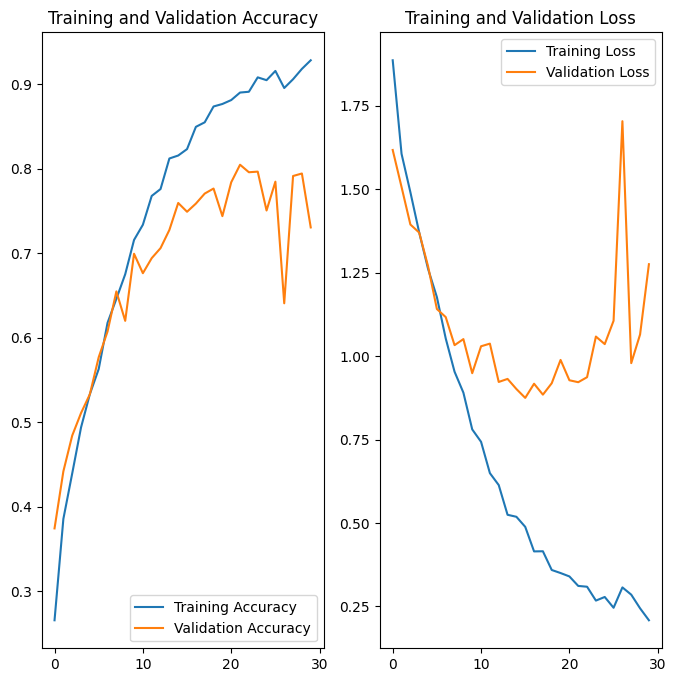

In [85]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [86]:
loss, accuracy = model.evaluate(train_ds, verbose=1,)
loss_v, accuracy_v = model.evaluate(val_ds, verbose=1)

print("Accuracy: ", accuracy)
print("Validation Accuracy: ",accuracy_v)
print("Loss: ",loss)
print("Validation Loss", loss_v)

43/43 [==============================] - 5s 106ms/step - loss: 1.2753 - accuracy: 0.7305
Accuracy:  0.8759273290634155
Validation Accuracy:  0.730512261390686
Loss:  0.33784204721450806
Validation Loss 1.2752883434295654


#### **Todo:**  Analyze your results here. Did you get rid of underfitting/overfitting? Did class rebalance help?




1.   Accuracy on training data has increased by using Augmentor library
2.   Model is still overfitting
3.   The problem of overfitting can be solved by add more layer,neurons or adding dropout layers.
4.  The Model can be further improved by tuning the hyperparameter









